## Importing The required Libraries

In [1]:
import pandas as pd

import chess
import chess.pgn

import time

###  List of Raw data files considered

In [ ]:
PGNfilNames = ['Modern.pgn','Reti2b3.pgn','Caro-Kann2c4.pgn','Caro-KannAdv.pgn','Caro-KannClassic.pgn','Caro-KannEx.pgn','FourKnights.pgn','GiuocoPiano.pgn','KingsGambit.pgn','Nimzowitsch-Larsen.pgn','QID4e3.pgn','RuyLopezMarshall.pgn','ScotchGambit.pgn','SicilianDragonOther6.pgn','SicilianRossolimo.pgn']

# Data Processor and suggestions Model (Frequent Pair Method)

## Support Functions for the Class

#### PGN Reader

In [ ]:
def PGNtoDF(PGNfilNames):
    """
    The input is list of pgn file names with dot extensions.
    Must be a list of strings even if there is only one element
    """
    AllGames = []
    for Nam in PGNfilNames:
        #Open PGN as Stream
        print('Opened',Nam)   # Printing the File names as confirmation
        PGNFile = open('Data/'Nam)                      # Please note the file Path for PGN Files
        
        TestGame = chess.pgn.read_game(PGNFile)
        Moves = TestGame.mainline()
        
        Game = PGNFile.read()
        TotalEvents = Game.count('[Event')    # finding total games available in the PGN file
        
        PGNFile.seek(0,0)                  # Going back to the file stating position
        
        
        for i in range(0,TotalEvents):     # based on the length of file we are 
            #Gam = ['modern']
            G = chess.pgn.read_game(PGNFile)
            Gam = list(G.headers.values())   # Fetching the game round details of players, date, etc..
            
            if len(Gam)< 10:                    # Checking for missing Data and appending with Empty Chars
                for i in range (0,10-len(Gam)):
                    Gam.append('')
            
            for j in range(0,len(Gam)):
                if '?' in Gam[j]:
                    Gam[j]=Gam[j].replace('?','0')  # Replacing ? and empty symbols with 0 to replace missing
                elif Gam[j]=='':
                    Gam[j] = 0
            
            Gam.append(Nam[:-4])                   # adding Opening as Tag
            
            
            Moves = str(G.mainline())             # getting the moves as PGN record counting the number of moves based on dot.
            SetLen = Moves.count('.')
            for j in range(0,Moves.count('.')+1):
                Remaining = Moves.count('.')
                Moves = Moves.replace(' '+str(j)+'.',' ')
                if Moves.count('.') == Remaining:
                    Moves = Moves.replace(str(j)+'.',' ')   # identifying any missig spaces and adding them
                
                Moves=Moves.replace('  ',' ')
              
            for j in range(0,SetLen):
                Moves = Moves.replace(' '+str(j)+' ',' ')   # adding the game length as a feature
            
            #Moves PGN to spaced string cleaner ends
            
            Gam.append(Moves)                           # adding cleaned moves and length to Dataframe list
            Gam.append(SetLen)
        
            AllGames.append(Gam)
    
    #converting the list of games data to a pandas Dataframe
    
    MainDF = pd.DataFrame(AllGames,columns = ['Event', 'Site', 'Date','Round','White','Black','Result','BlackElo','ECO','WhiteElo','Opening','Moves','SetLen'])
   
    # replacing some of the features with different labels and removing some major data Outliers
    
    MainDF['Result']=MainDF['Result'].apply(lambda X: 'W' if X=='1-0' else 'B' if X=='0-1' else 'D')
    MainDF['Moves'] = MainDF['Moves'].apply(lambda X : '' if not type(X)==str else X)
    
    #Creating a new feature for first opening move
    
    MainDF['Set1'] = MainDF['Moves'].apply(lambda X: X[0:10].split())
    MainDF['W1'] = MainDF['Set1'].apply(lambda X: X[0] if len(X)>0 else '')
    MainDF['B1'] = MainDF['Set1'].apply(lambda X: X[1] if len(X)>0 else '')
    
    return MainDF

#### Listing Out Unique Moves to create frequent Pairs

In [ ]:
def UniqueMoves(MovesList):
    lis = MovesList                   #recieve complete Moves from DatFrame as list and converting them to single String
    ans = str(MovesList)
    ans=ans.replace('[','')
    ans=ans.replace(']','')
    ans=ans.replace("'",'')          # Removing some of the list features like [ ] , and ' to combine all the lists to single large string
    ans=ans.replace(",",'')
    Splited = ans.split(' ')         # Keeping only unique moves to make a nxn matrix of pairs
    Unique=list(pd.Series(Splited).unique())
    Unique=Unique[0:Unique.index('')]+Unique[Unique.index('')+1:]  # Identifying and removing empty char 
    Whit = pd.DataFrame(0,columns=Unique,index=Unique)
    Blak = pd.DataFrame(0,columns=Unique,index=Unique)     # Making two matrixes 1 for [White,Black] pair and other for [Black, White] pair
    
    eachrow=[i.split(' ') for i in lis]    # splitting the list to game records to iterate game by game 
    
    for i in range(0,len(eachrow)):      # finding empty character in the game record to be removed from pair formation
        try:
            start = eachrow[i].index('')
        except:
            start = -1
        
        start = start+1
        
        for j in range(start,len(eachrow[i])-1):   # finding consecutive pairs and updating the value in matrix
            
            Pair = [eachrow[i][j],eachrow[i][j+1]]
            
            if (j-start)%2 ==0:
                Whit.loc[Pair[0],Pair[1]] = Whit.loc[Pair[0],Pair[1]]+1
            else:
                Blak.loc[Pair[0],Pair[1]] = Blak.loc[Pair[0],Pair[1]]+1
            
            #print(Whit.loc[Pair[0],Pair[1]],Blak.loc[Pair[0],Pair[1]])
            
    return[Whit,Blak]

#### Custom Filter Function for filtering based on number of moves and the side of the game (Black or White)

In [ ]:
def Filter(DF,MoveSet,Side=0):
    
    Filters = DF['Moves'].apply(lambda X: MoveSet in X[0:len(MoveSet)+2])    #Filtering the DataFrame for Moves. The DataFrame is already Filtered for Side.
    if Side!=0:
        Filtered = DF[DF['Result']==Side.capital()][Filters]                  #incase side is also parsed we detect which side needs to be considered.
    else:
        Filtered = DF[Filters]
    
    return Filtered

#### Creating a custom Model for Frequent Pairs method with help of above functions

Since Frequent pair model is not seen to be available with pre made libraries, we are creating custom frequent pair identification model.<br>All the above defined functions are used as support functions for the class.

In [ ]:
class ChessClass:
    
    def __init__(self):                          #Initializing the class with  Multiple required variables
        self.PGNFiles = []
        self.TotalDF = 0
        self.WhiteN=0
        self.BlackN=0
        self.Statistics =0
        self.CurrentFilter=0
        self.CurrentFilterDF=0
        self.FocusSide='W'
        self.FirstMoves = {}
        
        return
    
    def getFileNames(self,Names):                 # Get the file names in list.  File names should be in Name.ext format
        Flag = True     #everything is fine flag
        if type(Names)==str:
            N = Names.split(' ')
        elif type(Names)==list:
            N = Names
        
        for i in N:                #Showing User for any Error in file name.
            if not '.' in i :
                print('Dot Extension Not Found -->',i,"\nThe File Names should contain dot extension.")
                break
        
        if Flag:
            self.PGNFiles = N
        
        return
    
    def SetSide(self,Color):         #Set the model's game side. By default White 'W'. Can be changed to Black 'B' 
        self.FocusSide = Color
        return
    
    def getDF(self):
        self.TotalDF = PGNtoDF(self.PGNFiles)  # Get The Complete Dataset of the Games
        return
    
    def FilterDF(self,Opening):      #Filter the Dataset to reduce the Size and focused starting 
        self.CurrentFilterDF = Filter(self.TotalDF[self.TotalDF['Result']==self.FocusSide],Opening)
        return
    
    def FitDF(self):
        MoveList=self.CurrentFilterDF['Moves'].to_list()  # Creates frequent Unique pairs and their counts in NxN matrix
        
        [self.WhiteN,self.BlackN] = UniqueMoves(MoveList)
        
        return
    
    def ShowNextBest(self,Move,NextMoveCol):    # For given last move, and Next move's Colour, The most played moves are returned
        
        if NextMoveCol == 'B' or NextMoveCol == 'b' or NextMoveCol == 1:  # Based on next move's colour, The pairs matrix is determined.
            Stat = self.WhiteN.loc[Move,:][self.WhiteN.loc[Move,:]>0]
        elif NextMoveCol == 'W' or NextMoveCol == 'w' or NextMoveCol == 0:
            Stat = self.BlackN.loc[Move,:][self.BlackN.loc[Move,:]>0]
        else:
            print("Unknown Color passed -->",NextMoveCol,"\nValues can be 'W', or 'b'")
        
        
        print('Some of the Most played Moves are:\n',Stat)
        return Stat

#### Using The Above class to create a new Model

In [ ]:
Model = ChessClass()                  # Initiate frequent pair model
Model.getFileNames(PGNfilNames)  # notes what file to be read
Model.getDF()
Model.SetSide('W')               # Setting the game side for suggestions. White is the default side for model

In [ ]:
Model.FilterDF('e4 e5')          # filtereng the records based on provided set of moves. first move is white
Model.FitDF()                    # splits the frequent pairs based on [white,black] and [black,white]
Suggestions = Model.ShowNextBest('e5','W')     # get next move suggestions for this current move based on which side is making move next.

In [ ]:
print(Suggestions)

## Using The above Model to read the Complete Dataframe of all openings

Using the Above Model to get Complete DataSet.
(The Data Processing takes around 20 mins to read all the Files and the records result upto 236000 records approximately)

In [ ]:
CompleteSet = Model.TotalDF

In [2]:
CompleteSet = pd.read_csv('CompletePGN.csv')

In [3]:
W1 = CompleteSet['W1']
B1 = CompleteSet['B1']

#### Distribution of white's First move for all the considered PGN openings

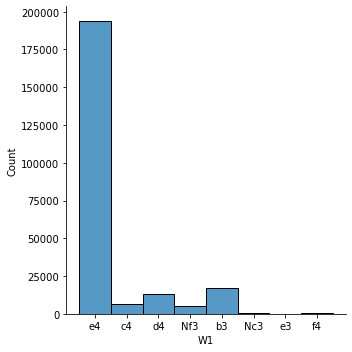

In [4]:
import seaborn as sb

sb.displot(W1)

#### Distribution of Black's first move

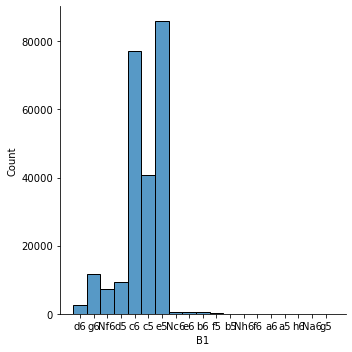

In [5]:
sb.displot(B1)

## Exploring Vectorized prediction for Decision Tree

#### Using Vectorised Game Moves as Prediction Features and Result of the game as Target feature

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import CountVectorizer

In [19]:
Movs = CompleteSet['Moves'].apply(lambda X: '' if type(X)!=str else X)
Movs=Movs.to_list()

Vect = CountVectorizer()

Corp = Vect.fit_transform(Movs)

In [20]:
Corp.shape

(236431, 3487)

In [10]:
Targ = CompleteSet['Result'].apply(lambda X: 1 if X=='W' else 2 if X=='B' else 0)

In [21]:
xtr,ytr,xts,yts = train_test_split(Corp, Targ, test_size=0.3)

In [24]:
import numpy as np

In [27]:
DTC = DecisionTreeClassifier()
DTC.fit(xtr.toarray(),ytr)
Pred = DTC.predict(xts)

In [ ]:
accuracy_score(yts,Pred)